In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import datetime
import matplotlib.cm as cm
import time
from sklearn.feature_selection import SelectKBest,f_regression,SelectFromModel,RFECV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from IPython.core.debugger import set_trace




# Load and cleaning data

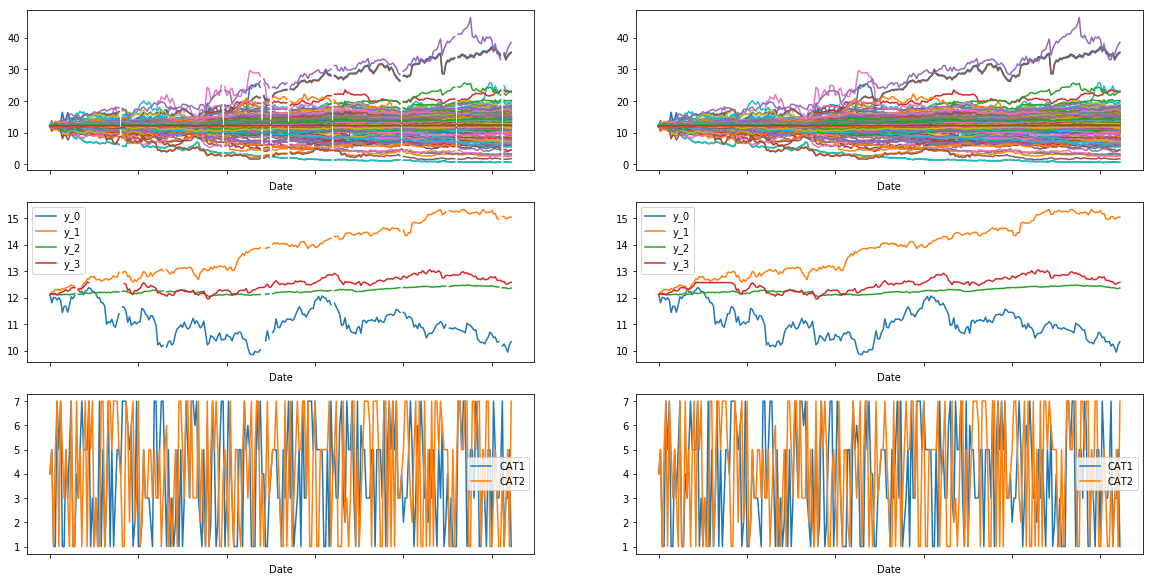


Shape of x after cleaning: (262, 444)


In [19]:
X = pd.read_csv('X.csv',index_col=0)
y = pd.read_csv('y.csv',index_col=0)
cat = pd.read_csv('categorical.csv',index_col=0)

#Visualize imported data and examine
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20,10))
X.plot(ax=axes[0,0],legend=False)
y.plot(ax=axes[1,0])
cat.plot(ax=axes[2,0])


'''bad_X = X.isnull()
bad_dates = bad_X.loc[bad_X.sum(axis=1)>0, :].sum(axis=1)

print('\nNumber of stocks whose price are NaN on these dates:')
print(bad_dates.T)

#drop dates that have multiple (>=2) NaN stock prices
dates_to_drop = list(bad_dates[bad_dates>1].index.values)
X.drop(dates_to_drop,inplace=True)

#drop the same dates in y and cat data
y.drop(dates_to_drop,inplace=True)
cat.drop(dates_to_drop,inplace=True)

bad_X = X.isnull()
bad_stocks = bad_X.loc[:, (bad_X.sum()>0)].sum()

print('\nStocks that still have NaN after dropping the bad dates')
print(bad_stocks)

#drop stocks that still have NaN prices
X.dropna(axis='columns', inplace=True)'''

#here we are using last observed data for missing values of stock prices
X.fillna(method='ffill', inplace=True)
y.fillna(method='ffill', inplace=True)
cat.fillna(method='ffill', inplace=True)

X.plot(ax=axes[0,1],legend=False)
y.plot(ax=axes[1,1])
cat.plot(ax=axes[2,1])
plt.show()

print('\nShape of x after cleaning:', X.shape)

## examine categorical

In [4]:
cat['CAT1'].value_counts()

5    68
1    59
3    50
7    47
2    12
6    10
4     6
Name: CAT1, dtype: int64

In [5]:
cat['CAT2'].value_counts()



7    76
1    66
5    59
3    37
2     8
6     5
4     1
Name: CAT2, dtype: int64

# preprocess routines

In [7]:
def identical_cat(I, cat):
    # sample from all dates with identical set of cat1 & cat2
    
    cat_group = cat.groupby(['CAT1','CAT2']).groups
    newI = [(pd.Series(cat_group[tuple(cat.iloc[I[i],:])]).sample()).iloc[0] for i in range(len(I))]
    
    return newI

In [9]:
def plotR2(R2_train, R2_test, maxN):
    '''plot adjusted R2 of training and testing dataset'''
    
    # set plot size and tick size
    plt.figure(figsize=(12,7))
    plt.tick_params(axis='both', which='major', labelsize=17)
    
    # plot training and testing datasets
    N = len(R2_train)
    p1, = plt.plot(range(1,N+1),R2_train,'b-*')
    p2, = plt.plot(range(1,N+1),R2_test,'r-*')
    
    # mark the data points corresponding to maxN
    plt.plot([maxN]*2,[0,np.max([R2_train[maxN-1],R2_test[maxN-1]])],'k--')
    plt.plot([0.5,maxN],[R2_train[maxN-1]]*2,'b--')
    plt.plot([0.5,maxN],[R2_test[maxN-1]]*2,'r--')
    plt.text(7,0.32,'Adj_R2 with '+str(maxN)+' elements:',fontsize=18)
    plt.text(7,0.25,'Train: '+str(round(R2_train[maxN-1],2)),fontsize=18)
    plt.text(7,0.2,'Test:  '+str(round(R2_test[maxN-1],2)),fontsize=18)
    
    # cosmetic
    plt.xticks(range(1,N+1))
    plt.title('Convergence of adjusted R2',fontsize=19)
    xlabel = 'No. of elements (max ' + str(maxN) + ')'
    plt.xlabel(xlabel,fontsize=17)
    plt.ylabel('Adjusted R2',fontsize=17)
    plt.ylim((0,1))
    plt.xlim((0.5,10.5))
    plt.legend([p1, p2], ['Train','Test'],fontsize=18,loc=4)
    
    plt.show()

In [10]:
def examine_features(dx, dy, plot, printout=True):
    '''Examine basket of dx to hedge dy using linear fit.
    plot and print R2 is optional. 
    Future work: compute t-stat and p values.'''
    
    if plot:
        plt.figure(figsize=(18, 16))
        plt.plot(range(dx.shape[0]),linear.predict(dx))
        plt.plot(range(dx.shape[0]),dy)
        plt.show()
    
    return R2_adj

In [11]:
def drop_corr_in_x(x, cutoff=0.9):
    '''Drop highly correlated columns from dx. c is the cutoff correlation level. '''     
    # calculate the correlation matrix of dx, and take the upper triangular of the 
    # matrix in order to find columns to drop
    corr_x = np.triu(np.corrcoef(x, rowvar=False), k=1)    
    drop_ind = np.nonzero(corr_x>cutoff)
    x.drop(x.columns[drop_ind[1]], axis=1, inplace=True)     
    return x


y_0 0.06599999999999999
Accuracy: 0.67 (+/- 0.96)
R2_adj_train=0.9254, R2_adj_test=0.9053 for selected features: Index(['x_1', 'x_18', 'x_41', 'x_127', 'x_240'], dtype='object')
with weights: [ 0.61520786  0.05356661  0.11223797  0.14437134 -0.12658668]


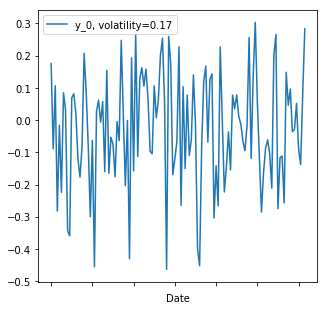

y_1 0.13100000000000003
Accuracy: -4.48 (+/- 12.23)
R2_adj_train=0.9361, R2_adj_test=0.9203 for selected features: Index(['x_1', 'x_14', 'x_77', 'x_111'], dtype='object')
with weights: [-0.17471868  0.88899257 -0.0749372   0.55361742]


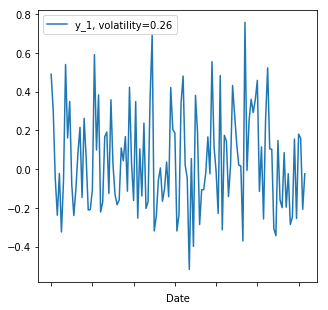

y_2 0.021
Accuracy: -0.61 (+/- 3.69)
R2_adj_train=0.7698, R2_adj_test=0.7401 for selected features: Index(['x_79', 'x_127', 'x_180', 'x_190'], dtype='object')
with weights: [0.06925972 0.05998892 0.43849953 0.13549629]


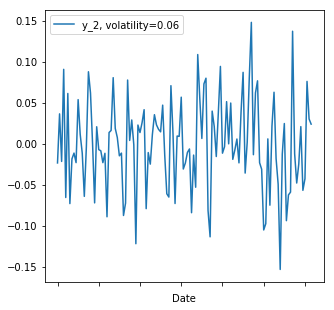

y_3 0.06599999999999999
Accuracy: 0.04 (+/- 0.68)
R2_adj_train=0.7843, R2_adj_test=0.7587 for selected features: Index(['x_14', 'x_54', 'x_101', 'x_236', 'x_296'], dtype='object')
with weights: [ 0.27859479 -0.21212347 -0.17830693  0.24689543  0.12750666]


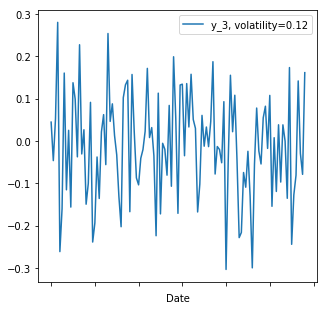

In [14]:
if __name__ == '__main__':
    
    test_ratio = 0.5
    n_best = 20
    n_limit = 5    
    k_fold = 5
    
    #??????????shall I apply cross validation here before any feature selection???????????
    #cross_val_score     
    
    #First drop those highly correlated features
    drop_corr_in_x(X, cutoff=0.9)
    
    #use the base estimator LassoCV since the L1 norm promotes sparsity of features.
    #use SelectFromModel to reduce the number of features to n_limit
    lrg = linear_model.LassoCV(cv = k_fold)
    sfm = SelectFromModel(lrg)
    X_train_trans = sfm.fit_transform(X_train, y_train)
    n_features = X_train_trans.shape[1]

    # Reset the threshold till the number of features less or equals n_limit.
    #set_trace()
    while n_features > n_limit:
        if sfm.threshold:
            sfm.threshold += 0.005
        else:
            sfm.threshold = 0.001
        X_train_trans = sfm.transform(X_train)
        n_features = X_train_trans.shape[1]

    X_test_trans = sfm.transform(X_test)
    features_sltd = X_test.columns[sfm.get_support()]
        
    print(target, sfm.threshold)
    #evaluate different models of selectors

    linear = linear_model.LinearRegression()
    linear.fit(X_train_trans, y_train)     
    weights = linear.coef_
    y_predict = linear.predict(X_test_trans)

    r2 = linear.score(X_train_trans, y_train)
    n = X_train_trans.shape[0]
    r2_adj_train = 1 - (1-r2)*(n-1)/(n-n_features-1)

    r2 = linear.score(X_test_trans, y_test)
    n = X_test_trans.shape[0]
    r2_adj_test = 1 - (1-r2)*(n-1)/(n-n_features-1)

    #calculate daily position and volatility
    posit = y_test-y_predict
    volat = posit.std()
        
    scores = cross_val_score(lrg, X_d, y_d, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
    print('R2_adj_train=%.4f, R2_adj_test=%.4f for selected features:'%(r2_adj_train, r2_adj_test), features_sltd)
    print('with weights:', weights)
    plt.figure(figsize=(5,5))
    posit.plot(label=target+', volatility=%.2f'%volat)
    plt.legend()
    plt.show()
                                               

                
    